## **1. Erode small bubbles on a dataset**

### Explanation of the Image Processing Code

This code processes a series of TIFF images in a folder to apply thresholding, erosion, and mask reconstruction. The final result is an image where the objects are isolated, with a white background replacing non-object areas. Here's a breakdown of the steps involved:

1. **Parameters for Erosion**: 
   - The number of erosion iterations is defined to refine the mask after thresholding.
2. **`process_image` Function**:
   - The function reads a TIFF image, applies Otsu's thresholding, and creates a binary mask.
   - It fills small enclosed spaces (contours) in the mask with white pixels to ensure object continuity.
   - An erosion operation is applied to the mask to remove small objects and noise.
   - The eroded mask is then used as a seed for mask reconstruction, which restores the larger objects removed during erosion.
   - The final image is created by copying the original image's pixels where the reconstructed mask is valid and replacing the rest with a white background.
3. **Saving the Results**:
   - The `save_image` function saves the processed images in PNG format.
4. **Main Processing**:
   - The main function searches for the "Original images Fxxxxxx-Fxxxxxx" folder, where the input TIFF images are stored, and the "Second visual layer of" folder, where the processed PNG images will be saved.
   - For each TIFF file in the "Original images F" folder:
     - The image is processed using the `process_image` function, which generates the original image, the mask before erosion, the mask after erosion, and the final image.
     - The final processed image is saved as a PNG file in the "Second visual layer of" folder.
   - A random TIFF image is selected for display. The original image, the mask before erosion, the mask after erosion and reconstruction, and the final processed image are all displayed in a multi-subplot figure for visual comparison.

This code is designed for use in JupyterLab and will display the results inline if run in that environment.

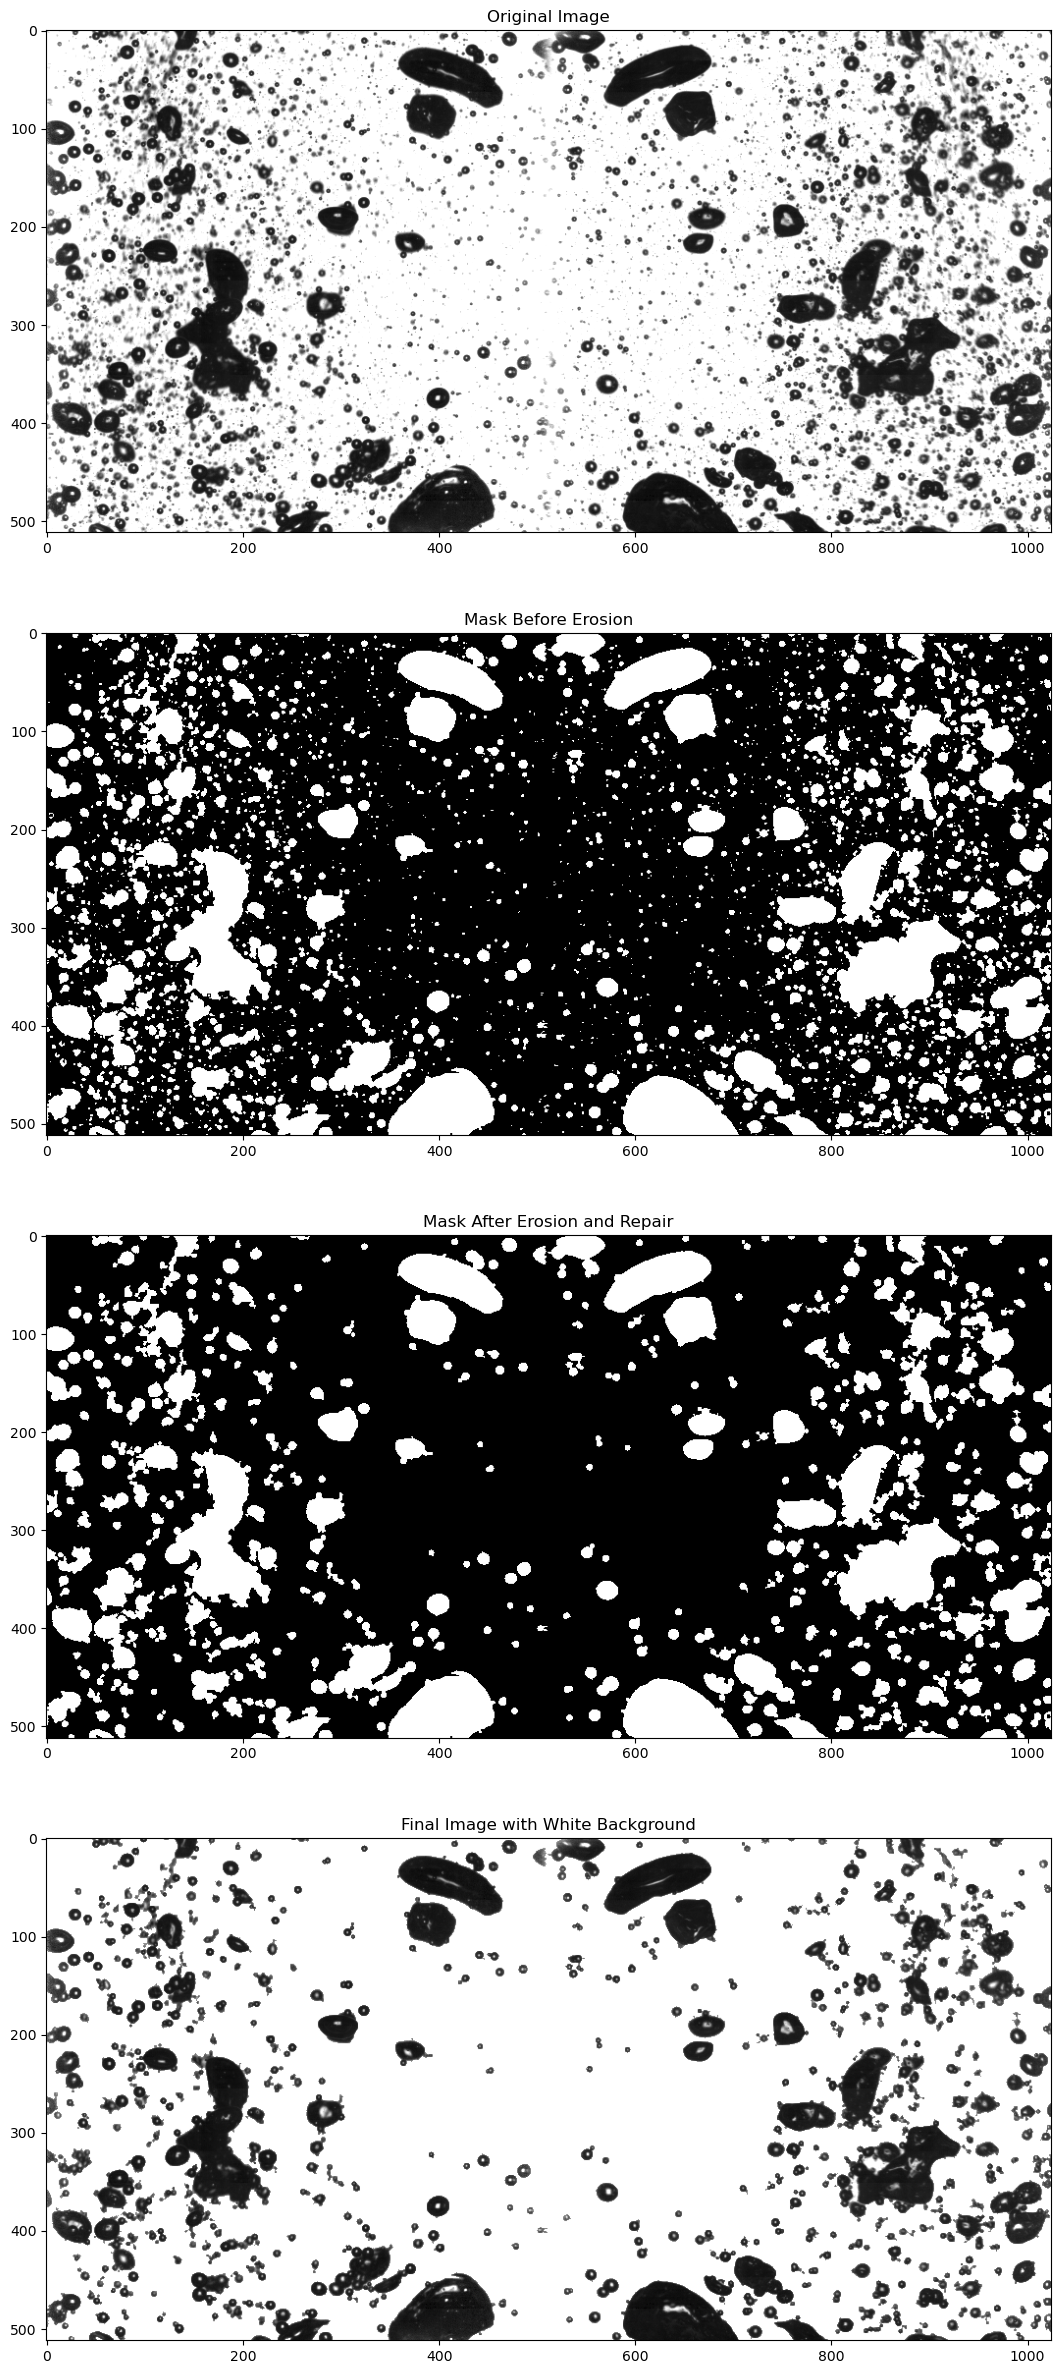

In [41]:
import os
import random
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from skimage.morphology import reconstruction
from scipy.ndimage import label

# Parameters for erosion and dilation
erosion_iterations = 2



def process_image(image_path, erosion_iterations=2):
    # Read the image
    original_image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

    # Check if the image was loaded successfully
    if original_image is None:
        print(f"Error: Image not found or could not be loaded from {image_path}")
        return None, None, None, None

    # Apply Otsu's thresholding
    _, otsu_thresh = cv2.threshold(original_image, 0, 4095, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Fill small enclosed spaces with white pixels
    filled_mask = cv2.normalize(otsu_thresh, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    contours, _ = cv2.findContours(filled_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        cv2.drawContours(filled_mask, [contour], -1, 255, thickness=cv2.FILLED)
    
    # Erode the filled mask to get rid of small objects
    eroded_mask = cv2.erode(filled_mask, None, iterations=erosion_iterations)

    # Use the eroded mask as the seed and the original filled mask as the reference for reconstruction
    seed = eroded_mask
    mask = filled_mask
    reconstructed_mask = reconstruction(seed, mask, method='dilation').astype(np.uint8)

    # Save the eroded mask before any further refinement
    mask_before_erosion = filled_mask.copy()

    # Create a white background
    white_background = np.ones_like(original_image, dtype=np.uint16) * 65535

    # Ensure the reconstructed mask has the same number of channels as the original image
    if len(original_image.shape) == 3:  # If the original image has multiple channels
        reconstructed_mask = np.repeat(reconstructed_mask[:, :, np.newaxis], original_image.shape[2], axis=2)

    # Create the final image by copying the original image where the reconstructed mask is non-zero and white elsewhere
    final_image = np.where(reconstructed_mask == 255, original_image, white_background)
    
    return original_image, mask_before_erosion, reconstructed_mask, final_image


# Function to save processed images as PNG
def save_image(image, save_path):
    Image.fromarray(image).save(save_path, format='PNG')

# Main processing
# Function to process all maps starting with "Fxxxxxx-Fxxxxxx"
def process_all_maps_with_cropping(crop_left, crop_right, crop_up, crop_down, split_mirror=False):
    current_directory = os.getcwd()
    cropping_info = []  # List to store cropping information for all folders

    # Iterate through all folders in the current directory
    for folder in os.listdir(current_directory):
        if folder.startswith("F") and "-" in folder:
            map_dir = os.path.join(current_directory, folder)

            # Process the specific folder structure
            original_images_dir = None
            for subfolder in os.listdir(map_dir):
                if subfolder.startswith("Background subtracted images F"):
                    original_images_dir = os.path.join(map_dir, subfolder)
                    break

            if original_images_dir is None:
                print(f"No 'Original images F' folder found in {folder}. Skipping.")
                continue

            # Process all TIFF files in "Original images F" folder
            tiff_files = [f for f in os.listdir(original_images_dir) if f.endswith('.tif')]
            if not tiff_files:
                print(f"No TIFF files found in 'Original images F' folder in {folder}. Skipping.")
                continue

            # Select a random image for displaying later
            random_image_file = random.choice(tiff_files)

            # Process all images (do not save them, just demonstrate cropping)
            for tiff_file in tiff_files:
                image_path = os.path.join(original_images_dir, tiff_file)
                darkened_image = process_image_with_cropping(
                    image_path, crop_left, crop_right, crop_up, crop_down, split_mirror)

                # Show the darkened image with the cropping area highlighted
                if tiff_file == random_image_file:
                    plt.figure(figsize=(10, 10))
                    plt.imshow(normalize_image(darkened_image))  # Show the image in true RGB colors
                    plt.title(f"Image with Cropping Area Highlighted - Map: {folder}")
                    plt.axis('off')
                    plt.show()

                    # Insert blank space by printing new lines (this acts as visual separation between groups)
                    print("\n" * 8)

            # Collect cropping information for this folder
            cropping_info.append(f"Cropping parameters for folder {folder}:")
            cropping_info.append(f"Crop left: {crop_left} pixels")
            cropping_info.append(f"Crop right: {crop_right} pixels")
            cropping_info.append(f"Crop up: {crop_up} pixels")
            cropping_info.append(f"Crop down: {crop_down} pixels")
            cropping_info.append(f"Split and mirror: {split_mirror}\n")

    # Save all cropping information to a single text file in the upper directory
    summary_file_path = os.path.join(current_directory, 'CroppingParameters.txt')
    with open(summary_file_path, 'w') as summary_file:
        summary_file.write("\n".join(cropping_info))


if __name__ == "__main__":
    main()



## **2. Investigation of accuracy of small bubbles**

### Analysis of Circle Area Accuracy and Erosion Iterations for Subpixel Diameters

This code calculates the accuracy of circle area measurements in pixel grids, considering subpixel offsets of the circle center. It also computes the number of erosion iterations required to completely remove the circle from a binary image. Small bubbles tend to form spherical shapes due to surface tension. For tiny bubbles, surface tension forces dominate over gravitational and other external forces. This results in the bubble minimizing its surface area, which forms a perfect sphere in order to achieve the lowest energy configuration. In this investigation, circular shapes represent the 2D projection of these bubbles in images, making circle-based calculations appropriate for analyzing bubble characteristics in the pixel grid.

Here’s a step-by-step breakdown of what the code does:

1. **Function Definitions**:
   - **`circle_area_pixels(diameter, center_x_offset, center_y_offset)`**: Calculates the area of a circle based on pixel coverage, taking into account subpixel offsets for the circle center. The function iterates over a grid of pixels and counts how many pixels fall inside the circle boundary.
   - **`actual_circle_area(diameter)`**: Calculates the actual area of a circle mathematically using the formula πr².
   - **`accuracy_calculation(pixel_area, actual_area)`**: Computes the percentage accuracy by comparing the pixel-based area of the circle to its actual area.
   - **`create_circle(diameter, center_x_offset, center_y_offset)`**: Generates a binary (black-and-white) image of a circle on a pixel grid, considering subpixel offsets for the center.
   - **`erosion_iterations_to_remove(circle)`**: Counts the number of erosion iterations needed to completely remove a circle from a binary image. Erosion is a process that shrinks objects in a binary image, and this function tracks how many iterations are required to make the circle disappear.
   - **`unique_offsets(subpixel_step)`**: Generates a list of unique subpixel offsets in one quadrant (0 to 0.5) for both x and y coordinates, based on the specified step size. This helps simulate different subpixel positions.

2. **Range of Diameters**:
   - A range of diameters is defined, including both integer and subpixel values, to evaluate how well the pixel grid approximates circles of various sizes. The diameters are spaced using a step of 0.02 pixels.

3. **Accuracy and Erosion Calculations**:
   - For each diameter, the code calculates the pixel-based circle area and the number of erosion iterations required to remove the circle, considering several subpixel offsets (generated by `unique_offsets`).
   - The accuracy of the pixel-based area is computed for each subpixel offset, and the average accuracy across all offsets is stored.
   - Asymmetric uncertainties (upper and lower bounds) are computed based on the differences between the maximum/minimum pixel areas and the average pixel area.

4. **Plotting**:
   - A plot is generated to visualize the accuracy of the circle area representation in the pixel grid for various diameters. The x-axis represents the circle diameter (including subpixel diameters), while the y-axis shows the percentage accuracy of the area compared to the actual circle area.
   - The plot includes the average accuracy curve, with error bars at integer diameters to indicate the uncertainty range due to subpixel offsets.
   - Upper and lower bounds are plotted as dashed lines around the accuracy curve.
   
5. **Erosion Iteration Axis**:
   - A second x-axis is created at the top of the plot, showing the sufficient number of erosion iterations required for complete removal of circles of corresponding diameters. This helps link the diameter of the circle to how many erosion steps are necessary to fully eliminate it.

6. **Customization**:
   - The x-axis for diameters is limited to values between 0 and 10, and the y-axis shows the accuracy from -10% to 160%. The ticks on the x-axis are set for every integer diameter, and grid lines are enabled for better visualization.

### Purpose:
The goal of this code is to analyze the accuracy of how circles, representing small bubbles, are captured in a pixel grid. By exploring the impact of subpixel offsets on area measurements, as well as the behavior of erosion iterations needed to fully remove circles from the grid, this investigation provides insights into both the precision of pixel-based representations and the morphological stability of small bubbles under pixel-level transformations.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_erosion
from shapely.geometry import Point, Polygon
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings("ignore", message="invalid value encountered in intersection")

# Use the default style to get a white background
plt.style.use('default')

def circle_area_pixels(diameter, center_x_offset=0.0, center_y_offset=0.0):
    """Calculate the area of a circle using a grid of pixels, considering pixel coverage exceeding 50%."""
    radius = diameter / 2
    grid_size = int(np.ceil(diameter))  # The grid size should cover the full diameter

    # Adjust grid size to account for the center offsets, adding padding if necessary
    x_padding = int(np.ceil(center_x_offset))
    y_padding = int(np.ceil(center_y_offset))
    grid_size += max(x_padding, y_padding)

    total_area = 0

    for i in range(grid_size):
        for j in range(grid_size):
            # Define pixel corners
            pixel_corners = [
                (i - 0.5, j - 0.5),
                (i + 0.5, j - 0.5),
                (i + 0.5, j + 0.5),
                (i - 0.5, j + 0.5)
            ]
            pixel_polygon = Polygon(pixel_corners)

            # Define the circle as a shapely object
            if diameter < 1:
                resolution = 50
            else:
                resolution = int(44 + diameter * 6)  # Use default scaling for larger diameters
            circle = Point(radius - center_x_offset, radius - center_y_offset).buffer(radius, resolution=resolution)
         
            # Compute the intersection area between the pixel and the circle
            intersection_area = pixel_polygon.intersection(circle).area

            # Count the pixel if the intersected area is more than 50% of the pixel area
            if intersection_area > 0.5:
                total_area += 1

    return total_area

def actual_circle_area(diameter):
    """Calculate the actual area of a circle given the diameter."""
    radius = diameter / 2
    return np.pi * radius ** 2

def accuracy_calculation(pixel_area, actual_area):
    """Calculate the accuracy between the pixel area and actual area."""
    if pixel_area == 0:
        return 0  # If no pixels represent the circle, accuracy is 0
    return (pixel_area / actual_area) * 100

def create_circle(diameter, center_x_offset=0.0, center_y_offset=0.0):
    """Create a binary image of a circle in a grid, considering the subpixel offset."""
    radius = diameter / 2
    grid_size = int(np.ceil(diameter))
    circle = np.zeros((grid_size, grid_size), dtype=bool)
    for i in range(grid_size):
        for j in range(grid_size):
            if ((i - radius + 0.5 + center_x_offset) ** 2 + 
                (j - radius + 0.5 + center_y_offset) ** 2) <= radius ** 2:
                circle[i, j] = 1
    return circle

def erosion_iterations_to_remove(circle):
    """Count the number of erosion iterations needed to completely remove the circle."""
    iterations = 0
    eroded_circle = circle.copy()
    while eroded_circle.any():
        eroded_circle = binary_erosion(eroded_circle)
        iterations += 1
    return iterations

def unique_offsets(subpixel_step, epsilon=1e-9):
    """Generate unique offsets for the subpixel center positions in one quadrant, using symmetry to compute only the upper triangle."""
    offsets = []
    for i in np.arange(0, 0.5 + subpixel_step, subpixel_step):
        for j in np.arange(0, 0.5 + subpixel_step, subpixel_step):
            if i >= j - epsilon:  # Ensure floating-point safety in comparison
                offsets.append((i, j))
    return offsets

# Define a range of diameters, including subpixel values
SubPixelStep = 0.01
MaxPixelDiameter = 20
diameters = np.linspace(0.5, MaxPixelDiameter, int((MaxPixelDiameter - 0.5) / SubPixelStep + 1))  # Includes both integer and subpixel values

accuracies = []
upper_uncertainties = []  # To store upper bound uncertainties
lower_uncertainties = []  # To store lower bound uncertainties


# Create a list to store all the simulation details
simulation_details = []

# Calculate accuracy and erosion iterations for each diameter considering subpixel positions
offsets = unique_offsets(SubPixelStep)

# Add progress bar for the loop
total_iterations = len(diameters) * len(offsets) * 2  # Total iterations considering symmetry

# Initialize progress bar
start_time = time.time()
with tqdm(total=total_iterations, desc="Processing Diameters") as pbar:
    for d in diameters:
        pixel_areas = []
        total_iterations_count = 0
        actual_area = actual_circle_area(d)
        
        # Calculate pixel area and erosion iterations for each subpixel offset
        for (offset_x, offset_y) in offsets:
            # Calculate for the current offset
            pixel_area = circle_area_pixels(d, center_x_offset=offset_x, center_y_offset=offset_y)
            circle = create_circle(d, center_x_offset=offset_x, center_y_offset=offset_y)
            iterations = erosion_iterations_to_remove(circle)
            pixel_areas.append(pixel_area)
            total_iterations_count += iterations
            
            # Save the simulation data
            simulation_details.append({
                'Diameter': d,
                'Center X Offset': offset_x,
                'Center Y Offset': offset_y,
                'Iterations for Full Erosion': iterations,
                'Pixel Diameter': pixel_area**0.5,
                'Accuracy': accuracy_calculation(pixel_area, actual_area)
            })
            
            # Mirror the result for (offset_x, offset_y) -> (offset_y, offset_x)
            if offset_x != offset_y:
                pixel_areas.append(pixel_area)
                total_iterations_count += iterations
                simulation_details.append({
                    'Diameter': d,
                    'Center X Offset': offset_y,
                    'Center Y Offset': offset_x,
                    'Iterations for Full Erosion': iterations,
                    'Pixel Diameter': pixel_area**0.5,
                    'Accuracy': accuracy_calculation(pixel_area, actual_area)
                })
            
            # Update progress bar
            pbar.update(2)  # We processed two offsets: (offset_x, offset_y) and its mirror (offset_y, offset_x)
        
        # Calculate the average and standard deviation of the pixel areas
        average_pixel_area = np.mean(pixel_areas)
        lower_uncertainty = np.percentile(pixel_areas, 2.5)  # 2.5th percentile
        upper_uncertainty = np.percentile(pixel_areas, 97.5)  # 97.5th percentile

        accuracy = accuracy_calculation(average_pixel_area, actual_area)
        accuracies.append(accuracy)

        # Convert to percentages of the actual area
        upper_uncertainties.append((upper_uncertainty - average_pixel_area) / actual_area * 100)
        lower_uncertainties.append((average_pixel_area - lower_uncertainty) / actual_area * 100)

# Save data for future use
np.save('simulation_details.npy', simulation_details)
np.save('accuracies.npy', accuracies)
np.save('upper_uncertainties.npy', upper_uncertainties)
np.save('lower_uncertainties.npy', lower_uncertainties)



Processing Diameters:  76%|█████████████████████████████████▏          | 3908950/5174052 [14:42:10<13:14:20, 26.54it/s]

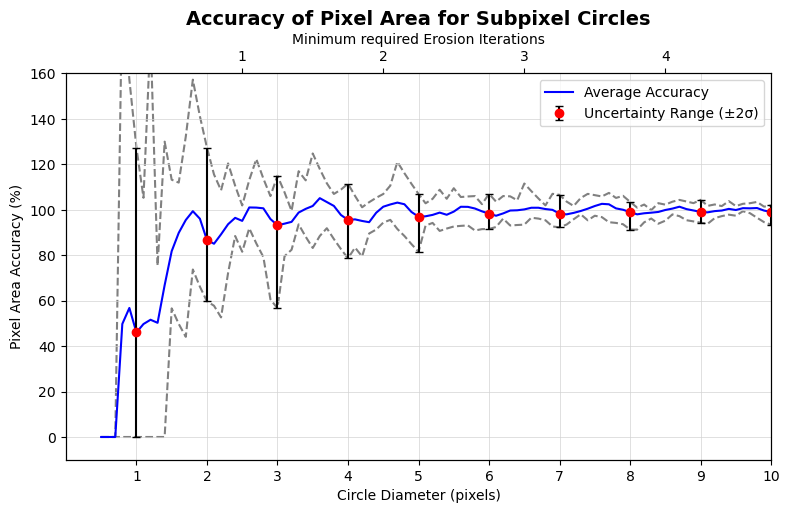

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Load previously saved data
simulation_details = np.load('simulation_details.npy', allow_pickle=True)
accuracies = np.load('accuracies.npy')
upper_uncertainties = np.load('upper_uncertainties.npy')
lower_uncertainties = np.load('lower_uncertainties.npy')

# Set up parameters for plotting
MaxPixelDiameter = 20
diameters = np.linspace(0.5, MaxPixelDiameter, int((MaxPixelDiameter - 0.5) / 0.1 + 1))

# Update the plotting section to show all integer ticks on the x-axis
fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.set_xlabel('Circle Diameter (pixels)')
ax1.set_ylabel('Pixel Area Accuracy (%)')

# Plot the accuracy curve
ax1.plot(diameters, accuracies, linestyle='-', color='b', label='Average Accuracy', linewidth=1.5)

# Calculate the upper and lower bounds for all diameters (using upper and lower uncertainties)
upper_bound = np.array(accuracies) + np.array(upper_uncertainties)
lower_bound = np.array(accuracies) - np.array(lower_uncertainties)

# Plot the yellow lines for upper and lower bounds
ax1.plot(diameters, upper_bound, linestyle='--', color='grey', linewidth=1.5, zorder=1)
ax1.plot(diameters, lower_bound, linestyle='--', color='grey', linewidth=1.5, zorder=1)

# Set the user-defined x-axis limits for the first axis
x_min = 0  # Change this to your desired minimum x-axis value
x_max = 10  # Change this to your desired maximum x-axis value

# Plot error bars only for the integer diameters (as before)
integer_diameters = np.arange(1, x_max + 1, 1)  # Integer diameters you want to highlight
indices = [np.argmin(np.abs(diameters - d)) for d in integer_diameters]
selected_accuracies = np.array(accuracies)[indices]
selected_upper_uncertainties = np.array(upper_uncertainties)[indices]
selected_lower_uncertainties = np.array(lower_uncertainties)[indices]

# Asymmetric error bars
ax1.errorbar(integer_diameters, selected_accuracies, 
             yerr=[selected_lower_uncertainties, selected_upper_uncertainties], 
             fmt='o', color='r', ecolor='black', capsize=3, label='Uncertainty Range (±2σ)')


# Set ticks on the x-axis for all integer values from 1 to MaxPixelDiameter
ax1.set_xticks(np.arange(1, MaxPixelDiameter + 1, 1))

# Calculate the last occurrence of each full erosion iteration
last_full_iterations = []
iteration_diameter_map = {}  # To store the first diameter for each iteration
last_diameters = []
step_size = diameters[1] - diameters[0]  # Assuming diameters are equally spaced

for i, d in enumerate(diameters):
    # For each diameter, use the maximum iteration across subpixel offsets
    max_iteration_for_diameter = int(np.max([simulation['Iterations for Full Erosion'] 
                                             for simulation in simulation_details 
                                             if simulation['Diameter'] == d]))
    
    # Skip iteration 0 and don't include it
    if max_iteration_for_diameter == 0:
        continue
    
    # Check if this iteration was seen before
    if max_iteration_for_diameter not in iteration_diameter_map:
        # Set the previous iteration's diameter to one step size before the current diameter
        if last_full_iterations:
            last_diameters[-1] = d - step_size
        
        # Track this iteration and diameter
        iteration_diameter_map[max_iteration_for_diameter] = d
        last_full_iterations.append(max_iteration_for_diameter)
        last_diameters.append(d)


# Create a second x-axis for erosion iterations, correctly mapped to the corresponding diameters
ax3 = ax1.twiny()

# Now sync the limits between ax1 and ax3 explicitly after both axes are created
ax3.set_xlim(ax1.get_xlim())  # Sync the limits with the first x-axis

# Use the last full integer values for the erosion iterations labeling
ax3.set_xticks(last_diameters)
ax3.set_xticklabels(last_full_iterations)
ax3.set_xlabel('Minimum required Erosion Iterations')

# Now adjust ax1 and ax3 together when setting new limits
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(-10, 160)
ax3.set_xlim(ax1.get_xlim())  # Re-sync limits after setting new ones

# Enable both horizontal and vertical grid lines
ax1.grid(visible=True, color='lightgray', linestyle='-', linewidth=0.5)

# Titles and legends
fig.tight_layout()
plt.title('Accuracy of Pixel Area for Subpixel Circles', fontsize=14, fontweight='bold')
ax1.legend()  # Add the legend here to avoid "no artists" warning
plt.show()


### Interactive Distribution Analysis for Erosion Iterations and Pixel Diameters

This JupyterLab cell enables interactive exploration of how accuracy is distributed across different iterations of erosion and pixel diameters for circles (representing bubbles) in a grid. This helps visualize how well circles are represented and removed through the erosion process.

#### Steps Explained:

1. **Loading Data**:
   - The cell loads two datasets, `object_details` and `simulation_details`, which contain accuracy and erosion information for circles of different pixel diameters and positions. The data is loaded using NumPy's `.npy` format, which allows for the storage of structured arrays.

2. **Grouping Data by Erosion Iterations**:
   - The first part of the code groups accuracy values by the number of erosion iterations required to completely remove each circle. This is done using a dictionary where the keys are the number of iterations, and the values are lists of accuracy values for the corresponding circles.

3. **Interactive Plot for Erosion Iterations**:
   - **Function `plot_distribution(iteration)`**: This function generates a histogram plot for the accuracy distribution of circles that were removed in a specified number of erosion iterations.
     - It uses `sns.histplot()` from Seaborn to create a histogram with a Kernel Density Estimate (KDE) overlay, showing how accuracy is distributed for each erosion iteration.
     - Vertical lines mark the mean accuracy as well as the coverage for 68% and 95% of the data, providing insights into the variation in accuracy.
     - An additional x-axis on the top of the plot shows the percentiles using sigma notation (e.g., ±1σ for 68% coverage and ±2σ for 95% coverage).
   - **Interactive Slider**: An `IntSlider` widget allows the user to select the number of erosion iterations. As the slider value changes, the corresponding accuracy distribution plot updates automatically.

4. **Grouping Data by Pixel Diameter**:
   - The second part of the code groups accuracy values based on the pixel diameter of each circle, which represents the size of the object in pixels. This grouping allows for analysis of how accuracy varies depending on the size of the circle.

5. **Interactive Plot for Pixel Diameters**:
   - **Function `plot_pixeldiameter_distribution(diameter)`**: This function generates a histogram plot for the accuracy distribution of circles with a specific pixel diameter.
     - The accuracy is plotted using a histogram with KDE, and the mean accuracy, 68%, and 95% coverage intervals are indicated with vertical lines.
     - This visualization helps understand how well circles of different sizes are captured in the pixel grid and whether smaller or larger diameters show greater variability in accuracy.
     - An additional x-axis on top shows percentiles (sigma notation), similar to the previous plot.
   - **Interactive Slider**: A second `IntSlider` widget allows the user to select a pixel diameter. The plot dynamically updates based on the selected diameter, showing how accuracy is distributed for circles of that specific size.

6. **Interactivity**:
   - Both plots allow for dynamic interaction through sliders. The user can explore different iterations or diameters by adjusting the slider, and the plots will automatically reflect the changes. This interactive approach makes it easier to analyze the relationship between accuracy, erosion iterations, and pixel diameter.

### Purpose:
This interactive analysis helps visualize the uncertainties and distribution of accuracy for bubble-like circles across different pixel diameters and erosion iterations. This is essential for understanding how well objects of various sizes are represented in pixel grids and how the erosion process affects their segmentation and removal.



In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, IntSlider
from collections import defaultdict
from IPython.display import clear_output


# Load the object details from the .npy file
simulation_details = np.load('simulation_details.npy', allow_pickle=True)

# Group the accuracies by the number of erosion iterations
grouped_simulation_details = {}
for detail in simulation_details:
    iterations = detail['Iterations for Full Erosion']
    if iterations not in grouped_simulation_details:
        grouped_simulation_details[iterations] = []
    grouped_simulation_details[iterations].append(detail['Accuracy'])


def get_ordinal_suffix(n):
    # Determine the suffix for the number
    if 10 <= n % 100 <= 20:
        suffix = 'th'
    else:
        suffix = {1: 'st', 2: 'nd', 3: 'rd'}.get(n % 10, 'th')
    return f'{n}{suffix}'


# Define the interactive plotting function
def plot_distribution(iteration):
    """Plot the accuracy distribution for circles removed in the given number of iterations."""
    fig, ax1 = plt.subplots(figsize=(12, 7))
    
    if iteration in grouped_simulation_details:
        data = grouped_simulation_details[iteration]
        # Plot the histogram with KDE
        iteration_label = get_ordinal_suffix(iteration)
        sns.histplot(data, bins=50, kde=True, color='b', alpha=0.6, label=f'{iteration_label} Iteration', stat='density', ax=ax1)


        
        # Calculate mean and percentiles for 68% and 95% coverage
        mean_value = np.mean(data)
        p68_lower = np.percentile(data, 16)  # 68% equivalent: 16th percentile
        p68_upper = np.percentile(data, 84)  # 68% equivalent: 84th percentile
        p95_lower = np.percentile(data, 2.5) # 95% equivalent: 2.5th percentile
        p95_upper = np.percentile(data, 97.5) # 95% equivalent: 97.5th percentile
        
        # Plot vertical lines for mean, 68% coverage, and 95% coverage
        ax1.axvline(mean_value, color='r', linestyle='--', linewidth=1.5, label=f'Mean: {mean_value:.1f}%')
        ax1.axvline(p68_upper, color='g', linestyle=':', linewidth=1.5, label=f'68% Coverage: {p68_lower:.1f}-{p68_upper:.1f}%')
        ax1.axvline(p68_lower, color='g', linestyle=':', linewidth=1.5)
        ax1.axvline(p95_upper, color='orange', linestyle='-.', linewidth=1.5, label=f'95% Coverage: {p95_lower:.1f}-{p95_upper:.1f}%')
        ax1.axvline(p95_lower, color='orange', linestyle='-.', linewidth=1.5)

        # Set the main plot details
        ax1.set_title(f'Accuracy Distribution for Circles Removed Exclusively in the {iteration} Erosion Iteration', fontsize=14)
        ax1.set_xlabel('Accuracy (%)')
        ax1.set_ylabel('Probability Density')
        ax1.legend()
        ax1.grid(True, linestyle='--', alpha=0.7)

        # Create an extra x-axis on top for percentiles
        ax2 = ax1.twiny()
        ax2.set_xlim(ax1.get_xlim())
        ax2.set_xticks([p95_lower, p68_lower, mean_value, p68_upper, p95_upper])
        ax2.set_xticklabels(['-2σ', '-1σ', 'Mean', '+1σ', '+2σ'])
    else:
        ax1.text(0.5, 0.5, 'No data available for this iteration', fontsize=12, ha='center', va='center')
        ax1.set_title(f'Accuracy Distribution for Circles Removed Exclusively in the {iteration} Erosion Iteration', fontsize=14)

    plt.show()

# Create an interactive slider for the number of erosion iterations
max_iterations = max(grouped_simulation_details.keys())-1  # Get the maximum number of iterations
slider = IntSlider(min=1, max=10, step=1, value=1, description='Erosion Iterations')

# Use interact to link the slider to the plot function
interact(plot_distribution, iteration=slider)


# Group accuracies by pixel diameter
grouped_by_diameter = {}
for detail in simulation_details:
    diameter = detail['Pixel Diameter']
    if diameter not in grouped_by_diameter:
        grouped_by_diameter[diameter] = []
    grouped_by_diameter[diameter].append(detail['Accuracy'])

def plot_pixeldiameter_distribution(diameter):
    """Plot the shifted accuracy distribution for circles of a specific pixel diameter."""
    fig, ax3 = plt.subplots(figsize=(12, 7))

    if diameter in grouped_by_diameter:
        data = grouped_by_diameter[diameter]
        # Plot the histogram with KDE for the shifted data
        sns.histplot(data, bins=20, kde=False, color='b', alpha=0.6, label=f'Pixel Diameter: {diameter:.1f} px', stat='density', ax=ax3)
        
        # Calculate mean and percentiles for 68% and 95% coverage (on shifted data)
        mean_value = np.mean(data)
        p68_lower = np.percentile(data, 16)
        p68_upper = np.percentile(data, 84)
        p95_lower = np.percentile(data, 2.5)
        p95_upper = np.percentile(data, 97.5)

        # Plot vertical lines for mean,68% coverage, and 95% coverage
        ax3.axvline(mean_value, color='r', linestyle='--', linewidth=1.5, label=f'Mean: {mean_value:.1f}%')
        ax3.axvline(p68_upper, color='g', linestyle=':', linewidth=1.5, label=f'68% Coverage: {p68_lower:.1f} to {p68_upper:.1f}')
        ax3.axvline(p68_lower, color='g', linestyle=':', linewidth=1.5)
        ax3.axvline(p95_upper, color='orange', linestyle='-.', linewidth=1.5, label=f'95% Coverage: {p95_lower:.1f} to {p95_upper:.1f}')
        ax3.axvline(p95_lower, color='orange', linestyle='-.', linewidth=1.5)
        
        # Set plot details
        ax3.set_title(f'Accuracy Distribution for Circles Captured with a Diameter of {diameter:.0f} Pixels', fontsize=14)
        ax3.set_xlabel('Shifted Accuracy (%)')
        ax3.set_ylabel('Probability Density')
        ax3.legend()
        ax3.grid(True, linestyle='--', alpha=0.7)

        # Extra x-axis for percentiles
        ax4 = ax3.twiny()
        ax4.set_xlim(ax3.get_xlim())
        ax4.set_xticks([p95_lower, p68_lower, mean_value, p68_upper, p95_upper])
        ax4.set_xticklabels(['-2σ', '-1σ', 'Mean', '+1σ', '+2σ'])
    else:
        ax4.text(0.5, 0.5, 'No data available for this diameter', fontsize=12, ha='center', va='center')
        ax4.set_title(f'Accuracy Distribution for Circles Captured with a Diameter of {diameter} Pixels', fontsize=14)

    plt.show()

# Create an interactive slider for selecting pixel diameter
max_diameter = max(grouped_by_diameter.keys())
slider_diameter = IntSlider(min=1, max=max_diameter , step=1, value=1, description='Pixel Diameter')

# Use interact to link the slider to the plot function
interact(plot_pixeldiameter_distribution, diameter=slider_diameter)

interactive(children=(IntSlider(value=1, description='Erosion Iterations', max=10, min=1), Output()), _dom_cla…

interactive(children=(IntSlider(value=1, description='Pixel Diameter', max=17, min=1), Output()), _dom_classes…

<function __main__.plot_pixeldiameter_distribution(diameter)>

## **3. Erode small bubbles on a dataset**


### Analysis and Interactive Visualization of Erosion Effects on Bubbles

This JupyterLab cell provides a comprehensive analysis of erosion effects on a set of TIFF images representing background-subtracted bubbles. It iteratively erodes the images, tracks the changes in the number and size of detected objects, and calculates the distribution of area shares by object diameter. The results are presented in interactive visualizations, allowing the user to explore the effects of erosion on bubble properties.

1. **Functions Overview**:
   - **`count_objects_and_areas(mask)`**: Counts connected components (objects) in a binary mask and returns the number of objects and their respective areas.
   - **`count_foreground_pixels(mask)`**: Counts the number of non-zero pixels in the binary mask.
   - **`calculate_extents(labels)`**: Computes the horizontal and vertical extents (width and height) for each detected object.
   - **`process_image(image_path, erosion_iterations)`**: Processes an image by applying thresholding, filling enclosed spaces, and performing erosion followed by reconstruction to obtain masks.
   - **`analyze_combined_erosion(tiff_files, original_images_dir)`**: Analyzes the erosion effects across all images, tracking changes in the total number of objects and pixels after each erosion iteration. It calculates percentages of objects and pixels lost and visualizes these changes using bar plots.
   - **`estimate_diameter(width, height)`**: Estimates the diameter of an object based on its minimum extent (width or height).
   - **`plot_diameter_area_share_interactive(object_details, start_index, range_size)`**: Plots the distribution of area share by object diameter, showing how the area is distributed among objects with different estimated diameters. The plot can be interactively adjusted to display different ranges of diameters.

2. **Main Analysis Workflow**:
   - The code searches for a directory named "Background subtracted images F" in the current working directory. If found, it gathers all TIFF files in this folder for analysis.
   - **Erosion Analysis**:
     - The code performs an initial analysis to count the total number of objects and pixels before any erosion.
     - It then iteratively erodes the images, continuing until no objects remain, and tracks the number of objects and pixels lost at each iteration.
     - It calculates the cumulative percentage of objects and pixels lost after each iteration, displaying these changes in bar plots for easy visualization.
   - The results, including object details such as pixel area, width, height, and number of iterations for full erosion, are saved to a file for further analysis.

3. **Interactive Visualization**:
   - **Loading Object Details**:
     - The saved object details are loaded from the file and converted back into a list of dictionaries for use in interactive visualizations.
   - **Interactive Diameter Distribution Plot**:
     - An interactive plot is created to explore the distribution of area shares by estimated object diameter before any erosion.
     - A slider allows the user to shift the scope of the displayed diameter range, enabling focused analysis on different subsets of diameters. The plot shows the percentage of total area occupied by objects of each diameter, with data labels for the area share values on the bars.
     - This interactive approach allows users to identify how the area distribution changes across different bubble sizes.

### Purpose:
The goal of this code is to:
   - Analyze how the erosion process affects bubble properties, providing insights into the stability and persistence of bubbles with varying sizes.
   - Visualize the distribution of object sizes and how their area contributions are distributed across different diameters, which can be useful for understanding the characteristics of bubbles in the original image set.
   - Offer an interactive way to explore the data, enabling a detailed examination of specific diameter ranges and erosion effects.

The combination of erosion analysis and interactive plotting helps in understanding the behavior of bubbles under morphological transformations, such as erosion, which is essential for applications in image processing and bubble segmentation.


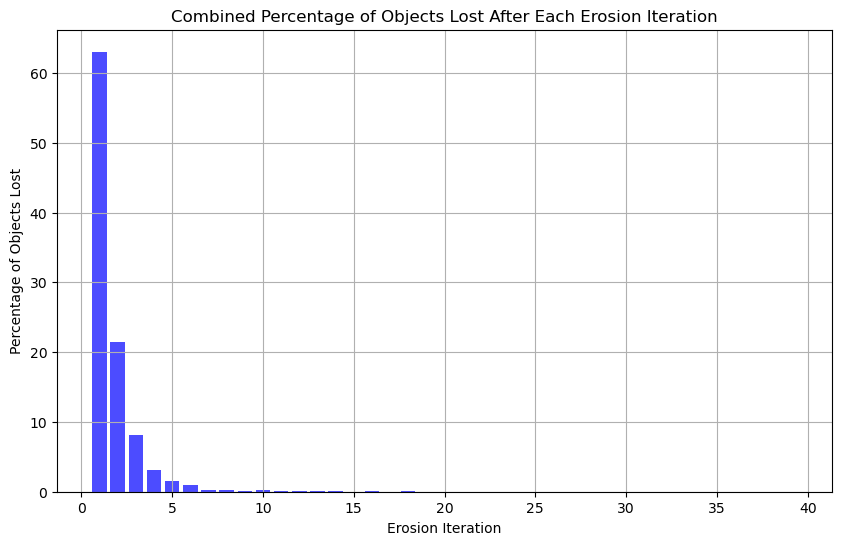

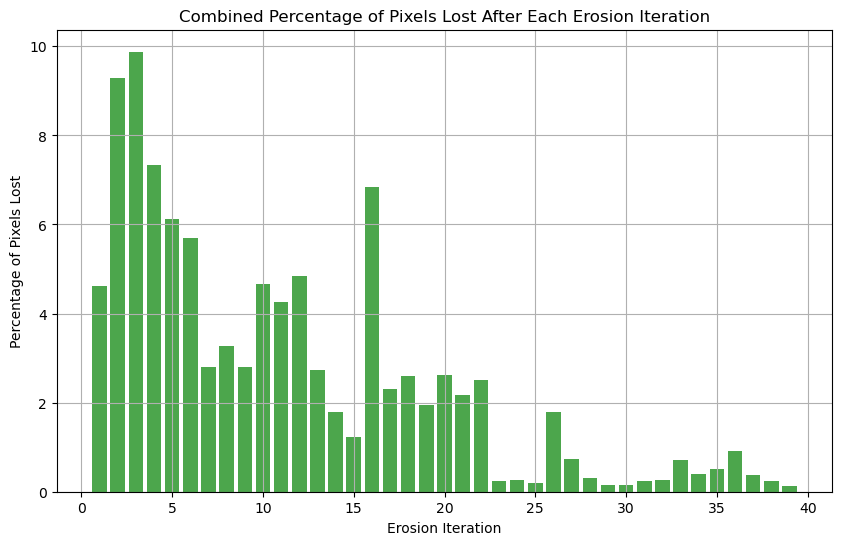

interactive(children=(IntSlider(value=0, description='start_index', max=90), Output()), _dom_classes=('widget-…

<function __main__.plot_diameter_area_share_interactive(object_details, start_index=0, range_size=15)>

In [8]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import reconstruction
from ipywidgets import interact, IntSlider

# Function to count connected components (objects) in the mask and return the areas (pixel counts) of each object
def count_objects_and_areas(mask):
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
    return num_labels - 1, stats[1:, cv2.CC_STAT_AREA]  # Exclude background

# Function to count the number of foreground (non-zero) pixels in the mask
def count_foreground_pixels(mask):
    return np.count_nonzero(mask)

# Function to calculate the horizontal and vertical extents of each connected component
def calculate_extents(labels):
    num_labels = np.max(labels)
    extents = []
    for label in range(1, num_labels + 1):
        y_coords, x_coords = np.where(labels == label)
        width = np.max(x_coords) - np.min(x_coords) + 1
        height = np.max(y_coords) - np.min(y_coords) + 1
        extents.append((width, height))
    return extents

# Function to process an image and return the masks
def process_image(image_path, erosion_iterations=2):
    original_image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    if original_image is None:
        return None, None

    # Apply Otsu's thresholding
    _, otsu_thresh = cv2.threshold(original_image, 0, 4095, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Fill small enclosed spaces with white pixels
    filled_mask = cv2.normalize(otsu_thresh, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    contours, _ = cv2.findContours(filled_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        cv2.drawContours(filled_mask, [contour], -1, 255, thickness=cv2.FILLED)

    # Erode and reconstruct the mask
    eroded_mask = cv2.erode(filled_mask, None, iterations=erosion_iterations)
    reconstructed_mask = reconstruction(eroded_mask, filled_mask, method='dilation').astype(np.uint8)
    
    return filled_mask, reconstructed_mask

# Function to analyze erosion results for all images combined
def analyze_combined_erosion(tiff_files, original_images_dir):
    iteration = 0
    total_objects_counts = []
    total_pixel_counts = []
    object_details = []  # To store object details

    # Initialize totals
    total_initial_objects = 0
    total_initial_pixels = 0

    # Process each image to gather initial totals
    for tiff_file in tiff_files:
        image_path = os.path.join(original_images_dir, tiff_file)
        filled_mask, _ = process_image(image_path, iteration)
        initial_objects, areas = count_objects_and_areas(filled_mask)
        initial_pixels = count_foreground_pixels(filled_mask)

        # Calculate extents for each object
        _, labels, _, _ = cv2.connectedComponentsWithStats(filled_mask, connectivity=8)
        extents = calculate_extents(labels)

        # Store object details for iteration 0
        for area, (width, height) in zip(areas, extents):
            if area > 0:  # Exclude any zero areas
                object_details.append({
                    'Pixel area': area,
                    'Pixel width': width,
                    'Pixel height': height,
                    'Iterations for Full Erosion': 0
                })
        
        # Accumulate totals
        total_initial_objects += initial_objects
        total_initial_pixels += initial_pixels

    # Record initial totals
    total_objects_counts.append(total_initial_objects)
    total_pixel_counts.append(total_initial_pixels)

    # Erode iteratively until no objects remain in all images
    while total_objects_counts[-1] > 0:
        iteration += 1
        current_objects = 0
        current_pixels = 0

        # Process each image for the current iteration
        for tiff_file in tiff_files:
            image_path = os.path.join(original_images_dir, tiff_file)
            _, reconstructed_mask = process_image(image_path, iteration)
            objects_count, areas = count_objects_and_areas(reconstructed_mask)
            pixel_count = count_foreground_pixels(reconstructed_mask)

            # Calculate extents for each object
            _, labels, _, _ = cv2.connectedComponentsWithStats(reconstructed_mask, connectivity=8)
            extents = calculate_extents(labels)

            # Store object details
            for area, (width, height) in zip(areas, extents):
                if area > 0:  # Exclude any zero areas
                    object_details.append({
                        'Pixel area': area,
                        'Pixel width': width,
                        'Pixel height': height,
                        'Iterations for Full Erosion': iteration
                    })

            # Accumulate current totals
            current_objects += objects_count
            current_pixels += pixel_count

        # Record results for the current iteration
        total_objects_counts.append(current_objects)
        total_pixel_counts.append(current_pixels)

    # Calculate cumulative percentages of objects and pixels lost per iteration
    objects_lost_percentage = [(total_objects_counts[i-1] - total_objects_counts[i]) / total_initial_objects * 100 
                               for i in range(1, len(total_objects_counts))]
    pixels_lost_percentage = [(total_pixel_counts[i-1] - total_pixel_counts[i]) / total_initial_pixels * 100 
                              for i in range(1, len(total_pixel_counts))]

    # Plot histograms for combined data
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, iteration + 1), objects_lost_percentage, color='blue', alpha=0.7)
    plt.xlabel('Erosion Iteration')
    plt.ylabel('Percentage of Objects Lost')
    plt.title('Combined Percentage of Objects Lost After Each Erosion Iteration')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.bar(range(1, iteration + 1), pixels_lost_percentage, color='green', alpha=0.7)
    plt.xlabel('Erosion Iteration')
    plt.ylabel('Percentage of Pixels Lost')
    plt.title('Combined Percentage of Pixels Lost After Each Erosion Iteration')
    plt.grid(True)
    plt.show()

    # Save object details for later use
    np.save('object_details.npy', object_details)


def estimate_diameter(width, height):
    return min(width, height)

import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, fixed

def plot_diameter_area_share_interactive(object_details, start_index=0, range_size=15):
    
    
    # Filter details for objects with 'Iterations for Full Erosion' equal to 0 (before any erosion)
    initial_objects = [obj for obj in object_details if obj['Iterations for Full Erosion'] == 0]
    
    # Estimate diameters and areas for these objects
    diameters = [estimate_diameter(obj['Pixel width'], obj['Pixel height']) for obj in initial_objects]
    areas = [obj['Pixel area'] for obj in initial_objects]
    
    # Group by unique diameters and calculate the total area for each diameter
    unique_diameters = sorted(set(diameters))
    total_area_per_diameter = [sum(area for dia, area in zip(diameters, areas) if dia == d) for d in unique_diameters]
    
    # Calculate the total area for all objects
    total_area = sum(areas)
    
    # Calculate the percentage of the total area for each diameter
    area_percentage = [(area / total_area) * 100 for area in total_area_per_diameter]
    
    # Select the portion of the graph based on the slider position
    end_index = min(start_index + range_size, len(unique_diameters))
    visible_diameters = unique_diameters[start_index:end_index]
    visible_area_percentage = area_percentage[start_index:end_index]

    # Plot the selected area share distribution with bars
    plt.figure(figsize=(14, 8))
    bars = plt.bar(visible_diameters, visible_area_percentage, color='blue', alpha=0.7, edgecolor='black')
    plt.xlabel('Estimated Diameter (Pixels)')
    plt.ylabel('Area Share (%)')
    plt.title('Distribution of Area Share by Object Diameter Before Any Erosion')
    plt.grid(True, axis='y')

    # Add data labels on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.1f}', va='bottom', ha='center', fontsize=8)

    # Set tick positions for visible diameters
    plt.xticks(visible_diameters, rotation=45)
    plt.show()

# Pre-compute unique diameters from object details
def get_unique_diameters(object_details):
    initial_objects = [obj for obj in object_details if obj['Iterations for Full Erosion'] == 0]
    diameters = [estimate_diameter(obj['Pixel width'], obj['Pixel height']) for obj in initial_objects]
    return sorted(set(diameters))



# Main function to run analysis on all images
def main():
    # Find "Background subtracted images F" directory
    current_directory = os.getcwd()
    original_images_dir = None
    for folder in os.listdir(current_directory):
        if folder.startswith("Background subtracted images F"):
            original_images_dir = os.path.join(current_directory, folder)
            break

    if original_images_dir is None:
        print("No 'Background subtracted images F' folder found. Exiting.")
        return

    # Collect all TIFF files in "Background subtracted images F" folder
    tiff_files = [f for f in os.listdir(original_images_dir) if f.endswith('.tif')]
    if not tiff_files:
        print("No TIFF files found in 'Background subtracted images F' folder. Exiting.")
        return

    # Perform combined analysis
    analyze_combined_erosion(tiff_files, original_images_dir)
    

if __name__ == "__main__":
    main()
    
# Load the object details from the .npy file
object_details = np.load('object_details.npy', allow_pickle=True)

# Convert the loaded data back to a list of dictionaries
object_details = object_details.tolist()

# Create an interactive slider for shifting the scope of the graph
max_index = len(set(diameter for diameter in [estimate_diameter(obj['Pixel width'], obj['Pixel height']) for obj in object_details]))
interact(plot_diameter_area_share_interactive, object_details=fixed(object_details), start_index=IntSlider(min=0, max=max_index - 30, step=1, value=0), range_size=fixed(30))





### Interactive Visualization of Accumulated Accuracy Distributions by Erosion Iterations

This JupyterLab cell provides an interactive visualization for exploring the accumulated accuracy distribution of object measurements (bubbles) up to a specified number of erosion iterations. The visualization is built step-by-step to precompute the necessary data, plot accumulated histograms, and allow users to interactively adjust the number of iterations to visualize.

1. **Data Loading and Conversion**:
   - The code loads the `object_details.npy` and `simulation_details.npy` files, converting them into lists of dictionaries. These files contain data about bubble properties, including pixel dimensions, erosion iterations, and accuracy.

2. **Data Preprocessing**:
   - **`preprocess_distributions()`**:
     - This function processes the data to link each object's accuracy to its corresponding diameter and iteration group.
     - The smaller dimension of the object is used as the "pixel diameter" to ensure consistency.
     - Objects are grouped by the number of erosion iterations needed for full removal, and their accuracy distributions are accumulated accordingly.
     - For iterations beyond the recorded maximum, perfect accuracy (100%) is assumed.
   - The results are stored in a `cumulative_distributions` dictionary for efficient plotting.

3. **Precomputed Histogram Data**:
   - Histogram data for each iteration group is precomputed using a fixed number of bins (50) to ensure consistency across different iterations. The histogram data includes counts and bin edges for each iteration group, enabling faster plotting.

4. **Interactive Plotting Function**:
   - **`plot_accumulated_distributions(iteration)`**:
     - This function plots the accumulated accuracy distribution up to a given number of erosion iterations, showing how accuracy evolves as more erosion iterations are considered.
     - It retrieves precomputed histogram data for the specified iteration and plots it using a bar graph.
     - Vertical lines indicate key statistics:
       - **Mean accuracy** is marked with a dashed red line.
       - **68% coverage (equivalent to ±1σ in a normal distribution)** is marked with green dotted lines.
       - **95% coverage (equivalent to ±2σ in a normal distribution)** is marked with orange dash-dot lines.
     - An additional x-axis on top shows these key statistics in terms of standard deviations (σ).
     - If no data is available for the selected iteration, a message is displayed indicating that no data exists.

5. **Interactive Slider**:
   - An `IntSlider` widget allows the user to adjust the number of erosion iterations (from 0 to a maximum value of 10). This slider is linked to the `plot_accumulated_distributions()` function, allowing the histogram to update dynamically as the slider is moved.

### Purpose:
The goal of this code is to:
   - Analyze how erosion iterations affect the accuracy of bubble measurements by visualizing the accumulated accuracy distributions for various iteration counts.
   - Provide interactive control to allow users to explore how accuracy evolves as more erosion iterations are considered. This is useful for understanding the stability of bubble properties across different morphological transformations.
   - Highlight the statistical distribution of accuracy using visual markers for mean and standard deviation coverage (68% and 95%).

This interactive approach enables a detailed examination of erosion effects on accuracy, offering insights into the behavior of bubble segmentation under varying degrees of erosion.


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from IPython.display import clear_output
from ipywidgets import interact, IntSlider




# Load the object details from the .npy file
object_details = np.load('object_details.npy', allow_pickle=True)
simulation_details = np.load('simulation_details.npy', allow_pickle=True)

# Convert the loaded data back to a list of dictionaries
object_details = object_details.tolist()
simulation_details = simulation_details.tolist()


# Preprocess data to link objects to diameter distributions and accumulate results for each iteration group
def preprocess_distributions():
    processed_distributions = defaultdict(list)

    # Iterate over all objects in the object details
    for detail in object_details:
        diameter = min(detail['Pixel width'], detail['Pixel height']) # Use the smaller dimension as the "pixel diameter"
        iterations = detail['Iterations for Full Erosion']
        
        # Link each object to the appropriate distribution based on its pixel diameter
        if diameter in grouped_by_diameter:
            accuracies_for_diameter = grouped_by_diameter[diameter]
            # Add all the accuracies for this diameter to the appropriate iteration group
            processed_distributions[iterations].extend(accuracies_for_diameter)

    # For iterations above the max recorded, consider them exact
    max_iterations = max(simulation_details, key=lambda x: x['Iterations for Full Erosion'])['Iterations for Full Erosion']
    for detail in object_details:
        if detail['Iterations for Full Erosion'] > max_iterations - 1:
            # Link these to the last iteration (treated as exact without deviation)
            processed_distributions[max_iterations].append(100.0)  # Perfect accuracy assumption

    return processed_distributions

# Precompute the cumulative distributions for efficient plotting
cumulative_distributions = preprocess_distributions()

# Step 2: Precompute histogram data for each iteration
histogram_data = {}
for iteration, data in cumulative_distributions.items():
    # Precompute histogram with fixed number of bins for consistency
    counts, bin_edges = np.histogram(data, bins=50, density=True)
    histogram_data[iteration] = (counts, bin_edges)

# Step 3: Plot accumulated distributions for a given iteration using precomputed histogram data
def plot_accumulated_distributions(iteration):
    """Plot the accumulated accuracy distribution for all iterations up to the given number."""
    clear_output(wait=True)  # Clear previous output to avoid multiple plots

    # Retrieve precomputed histogram data
    counts, bin_edges = histogram_data.get(iteration, (None, None))

    # Plotting
    fig, ax1 = plt.subplots(figsize=(12, 7))

    if counts is not None:
        # Plot the histogram using precomputed data
        ax1.hist(bin_edges[:-1], bin_edges, weights=counts, color='b', alpha=0.6, label=f'Accumulated up to {iteration} Iterations')

        # Calculate mean and percentiles for 68% and 95% coverage
        data = cumulative_distributions[iteration]
        mean_value = np.mean(data)
        p68_lower = np.percentile(data, 16)
        p68_upper = np.percentile(data, 84)
        p95_lower = np.percentile(data, 2.5)
        p95_upper = np.percentile(data, 97.5)

        # Plot vertical lines for mean, 68%, and 95% coverage
        ax1.axvline(mean_value, color='r', linestyle='--', linewidth=1.5, label=f'Mean: {mean_value:.1f}%')
        ax1.axvline(p68_upper, color='g', linestyle=':', linewidth=1.5, label=f'68% Coverage: {p68_lower:.1f}-{p68_upper:.1f}%')
        ax1.axvline(p68_lower, color='g', linestyle=':', linewidth=1.5)
        ax1.axvline(p95_upper, color='orange', linestyle='-.', linewidth=1.5, label=f'95% Coverage: {p95_lower:.1f}-{p95_upper:.1f}%')
        ax1.axvline(p95_lower, color='orange', linestyle='-.', linewidth=1.5)

        # Plot details
        ax1.set_title(f'Accumulated Accuracy Distribution up to {iteration} Erosion Iterations', fontsize=14)
        ax1.set_xlabel('Accuracy (%)')
        ax1.set_ylabel('Probability Density')
        ax1.legend()
        ax1.grid(True, linestyle='--', alpha=0.7)

        # Add an extra x-axis for percentiles
        ax2 = ax1.twiny()
        ax2.set_xlim(ax1.get_xlim())
        ax2.set_xticks([p95_lower, p68_lower, mean_value, p68_upper, p95_upper])
        ax2.set_xticklabels(['-2σ', '-1σ', 'Mean', '+1σ', '+2σ'])
    else:
        ax1.text(0.5, 0.5, 'No data available for this iteration', fontsize=12, ha='center', va='center')
        ax1.set_title(f'Accumulated Accuracy Distribution up to {iteration} Erosion Iterations', fontsize=14)

    plt.show()

# Step 4: Set up an interactive slider to visualize results for different iteration steps
max_iterations = 10
slider = IntSlider(min=0, max=max_iterations, step=1, value=0, description='Erosion Iterations')

# Use interact to link the slider to the plot function
interact(plot_accumulated_distributions, iteration=slider)


interactive(children=(IntSlider(value=0, description='Erosion Iterations', max=10), Output()), _dom_classes=('…

<function __main__.plot_accumulated_distributions(iteration)>

### Explanation of Statistical Analysis of Accuracy After Erosion Iterations

This cell calculates and plots key statistics (mean, standard deviation, and confidence intervals) for accuracy across different erosion iterations:

1. **Compute Statistics**:
   - The function `compute_statistics` calculates the mean, standard deviation, and confidence intervals (68% and 95%) for accuracy at each erosion iteration.
   
2. **Plotting**:
   - The plot shows how the mean accuracy changes with erosion iterations, with shaded areas representing ±1σ (68%) and ±2σ (95%) ranges.
   - This provides a visual understanding of how accuracy and its variation behave as the number of iterations increases.


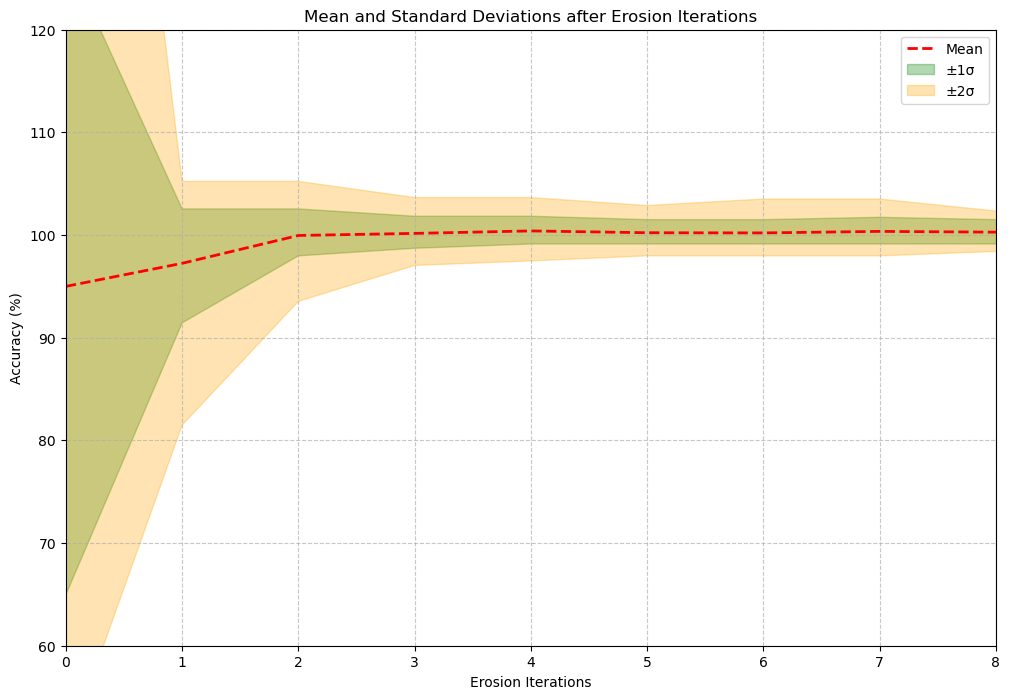

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'cumulative_distributions' contains your accuracy data for each iteration

def compute_statistics(cumulative_distributions):
    stats = []
    for iteration, data in cumulative_distributions.items():
        mean_value = np.mean(data)
        std_dev = np.std(data)
        p68_lower = np.percentile(data, 16)
        p68_upper = np.percentile(data, 84)
        p95_lower = np.percentile(data, 2.5)
        p95_upper = np.percentile(data, 97.5)
        
        stats.append({
            'Iteration': iteration,
            'Mean': mean_value,
            'Standard Deviation': std_dev,
            '68% Lower': p68_lower,
            '68% Upper': p68_upper,
            '95% Lower': p95_lower,
            '95% Upper': p95_upper
        })
    return stats

# Compute statistics
statistics = compute_statistics(cumulative_distributions)

# Extract values for plotting
iterations = [stat['Iteration'] for stat in statistics]
means = [stat['Mean'] for stat in statistics]
std_devs = [stat['Standard Deviation'] for stat in statistics]
sigma_68_upper = [stat['68% Upper'] for stat in statistics]
sigma_68_lower = [stat['68% Lower'] for stat in statistics]
sigma_95_upper = [stat['95% Upper'] for stat in statistics]
sigma_95_lower = [stat['95% Lower'] for stat in statistics]

# Plot the first graph: Mean, Standard Deviation, and ±2σ against Erosion Iterations
plt.figure(figsize=(12, 8))
plt.plot(iterations, means, label='Mean', color='r', linestyle='--', linewidth=2)
plt.fill_between(iterations, sigma_68_lower, sigma_68_upper, color='g', alpha=0.3, label='±1σ')
plt.fill_between(iterations, sigma_95_lower, sigma_95_upper, color='orange', alpha=0.3, label='±2σ')
plt.xlabel('Erosion Iterations')
plt.ylabel('Accuracy (%)')
plt.title('Mean and Standard Deviations after Erosion Iterations')
plt.xlim(0, 8)
plt.ylim(60, 120)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()







### Explanation of Area Loss vs. Standard Deviations Plot

This cell computes and plots the relationship between the area loss during erosion and the transformed standard deviations (1σ and 2σ) of accuracy:

1. **Area Loss Calculation**:
   - It calculates the percentage of total area lost after each erosion iteration relative to the initial area of all objects.

2. **Transformed Standard Deviations**:
   - The first (68% confidence) and second (95% confidence) standard deviations are calculated and plotted against the area loss.

3. **Plot**:
   - The plot shows how the standard deviations change as objects are progressively eroded and the area decreases, with both the primary axis (area loss) and a secondary axis (iterations) for reference.


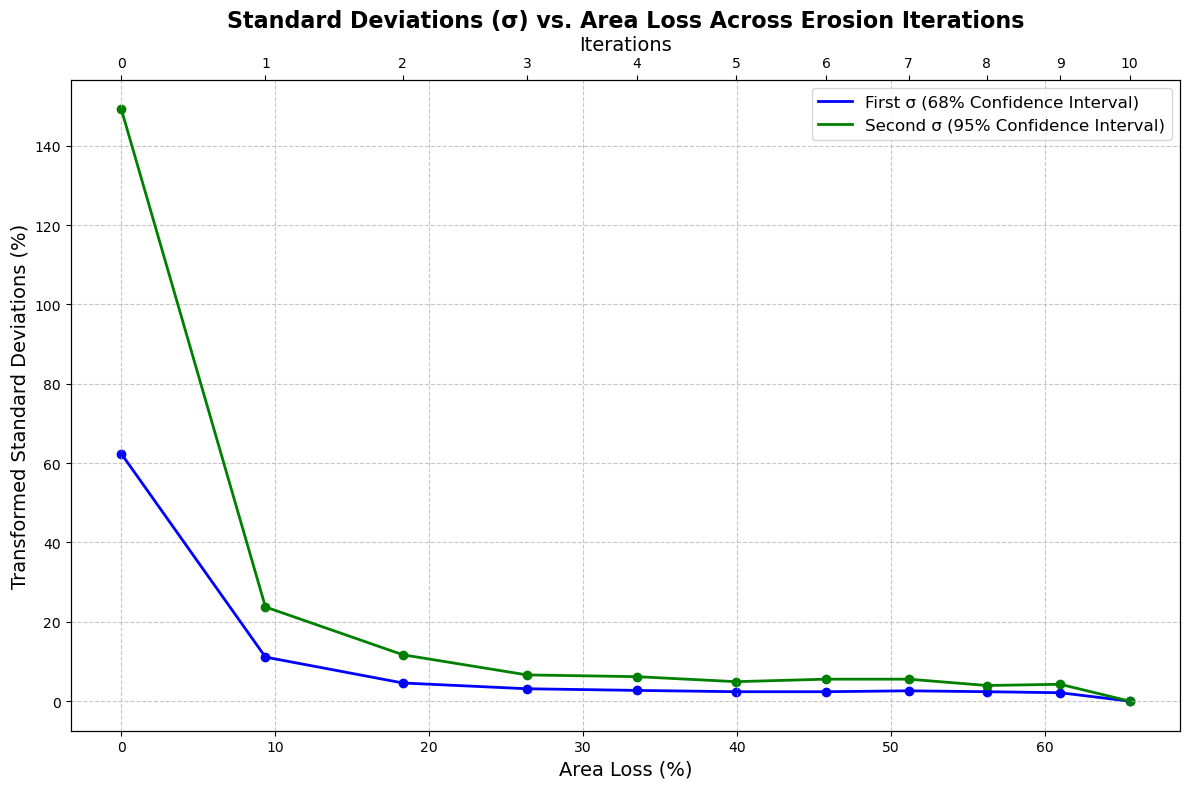

In [14]:
# Calculate transformed data for the second graph
first_std_transformed = [(sigma_68_upper[i] - sigma_68_lower[i])  for i in range(len(sigma_68_upper))]
second_std_transformed = [(sigma_95_upper[i] - sigma_95_lower[i])  for i in range(len(sigma_95_upper))]

# Calculate the initial total area (before erosion)
initial_area = sum(obj['Pixel area'] for obj in object_details if obj['Iterations for Full Erosion'] >= 0)

# Calculate the total area for each iteration
max_iterations = max(obj['Iterations for Full Erosion'] for obj in object_details)
total_area_per_iteration = []

for iteration in range(max_iterations + 1):
    total_area = sum(obj['Pixel area'] for obj in object_details if obj['Iterations for Full Erosion'] >= iteration)
    total_area_per_iteration.append(total_area)

# Calculate area loss as a percentage of the initial total area
arealoss = [(1 - (area / initial_area)) * 100 for area in total_area_per_iteration]

# Ensure arealoss is in correct range
arealoss = [max(0, min(100, al)) for al in arealoss]


# Find the minimum length between the area loss and standard deviation data
min_length = min(len(arealoss), len(first_std_transformed))

# Truncate both lists to the same length
arealoss = arealoss[:min_length]
first_std_transformed = first_std_transformed[:min_length]
second_std_transformed = second_std_transformed[:min_length]

# Create a figure and axis for the second graph, matching the size of the first one
fig, ax = plt.subplots(figsize=(12, 8))  # Same size as the first plot

# Plot the first transformed sigma
ax.plot(arealoss, first_std_transformed, label='First σ (68% Confidence Interval)', color='blue', linestyle='-', linewidth=2)
ax.scatter(arealoss, first_std_transformed, color='blue')  # Add dots for each data point

# Plot the second transformed sigma
ax.plot(arealoss, second_std_transformed, label='Second σ (95% Confidence Interval)', color='green', linestyle='-', linewidth=2)
ax.scatter(arealoss, second_std_transformed, color='green')  # Add dots for each data point

# Set labels for the primary x-axis (Area Loss) and y-axis
ax.set_xlabel('Area Loss (%)', fontsize=14)
ax.set_ylabel('Transformed Standard Deviations (%)', fontsize=14)

# Create a secondary x-axis for iterations, ensuring it matches the size and layout of the first graph
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())  # Match the x-axis limits with the original plot
ax2.set_xticks(arealoss)     # Use the same ticks as the area loss
ax2.set_xticklabels([str(i) for i in range(len(arealoss))], fontsize=10)  # Label with iteration numbers only
ax2.set_xlabel('Iterations', fontsize=14)

# Set title with the same size and style as the first plot
ax.set_title('Standard Deviations (σ) vs. Area Loss Across Erosion Iterations', fontsize=16, fontweight='bold')

# Set up the legend with the same style as the first graph
ax.legend(fontsize=12, loc='best')

# Ensure the grid settings are consistent
ax.grid(True, linestyle='--', alpha=0.7)

# Adjust the layout to ensure the plot fits nicely
plt.tight_layout()

# Show the second plot
plt.show()